https://fastai1.fast.ai/troubleshoot.html

In [9]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from fastai.data.all import *
from fastai.vision.all import *
from patchify import patchify
from PIL import Image

BATCH_SZ = 8
PATCH_SZ = 256 # must be a multiple of the image size, obviously

#torch.device("cpu")

#fastai.defaults.device = "cpu"
#defaults.device = "cpu"
#!export CUDA_VISIBLE_DEVICES=""

[https://walkwithfastai.com/Segmentation]

### Pre-pipeline processing with patchify

In [10]:
# simpler implementation, more readable if perhaps less dry...
def extract_patches(full_arr, sz=PATCH_SZ):
    patch_list = []
    if len(full_arr.shape) < 3 : # account for no channel dim (masks)
        patch_arr = patchify(full_arr, (sz, sz), sz)
        for i in range(patch_arr.shape[0]):
            for j in range(patch_arr.shape[1]):
                patch_list.append(patch_arr[i,j,:,:])
    
    else:
        channels = full_arr.shape[-1]
        patch_arr = patchify(full_arr, (sz, sz, channels), sz)
        for i in range(patch_arr.shape[0]):
            for j in range(patch_arr.shape[1]):
                patch_list.append(patch_arr[i,j,:,:,:])


    return patch_list

In [18]:
#TODO - screw around calculating class imbalance

def get_all_patches(path):
    """
    Given an input data directory,
    returns a list with tuples of form (img_patch, msk_patch)
    """
    
    def get_arrays(path):
        #This NEEDS to be sorted or everything else will be messed up...
        paths = sorted(path.glob("*"))
        return [np.array(Image.open(path)) for path in paths]

    img_arrs = get_arrays(path/"images")
    msk_arrs = get_arrays(path/"targets")

    img_patches = [extract_patches(img_arr) for img_arr in img_arrs]
    msk_patches = [extract_patches(msk_arr) for msk_arr in msk_arrs]

    img_patches = [patch for patches in img_patches for patch in patches]
    msk_patches = [patch for patches in msk_patches for patch in patches]

    # extra processing-- not efficient, but necessary!
    img_patches = [patch.squeeze() for patch in img_patches]
    msk_patches = [patch.squeeze() for patch in msk_patches]

    all_patches = list(zip(img_patches, msk_patches))

    return all_patches

# don't optimize prematurely! >:3

def save_patches(patches, output_dir):
    """
    given patches and an output dir, save all patches
    """
    total = len(patches)
    for i, (img, msk) in enumerate(patches):
        Image.fromarray(img).save(output_dir/"images"/f"{i}.png")
        Image.fromarray(msk).save(output_dir/"targets"/f"{i}.png")
        print(f"Saved tuple {i}/{total}", end="\r", flush=True)
    print(end="\r", flush=True)


In [19]:

base_path = Path("../data/")
data_dir = base_path/"full"/"post-disaster"
patch_dir = base_path/f"{PATCH_SZ}_patches"


if not patch_dir.is_dir():
    # make necessary directories
    patch_dir.mkdir()
    (patch_dir/"images").mkdir()
    (patch_dir/"targets").mkdir()

    print("extracting patches...")
    patches = get_all_patches(data_dir)
    print("saving patches...")
    save_patches(patches, patch_dir)
    print("all patches saved!")
else:
    print("patches already extracted! skipping.")


extracting patches...
saving patches...
Saved tuple 3087/3088all patches saved!


### Make Dataset

In [20]:
codes = ["Background", "NoDamage", "MinorDamage", "MajorDamage", "Destroyed"]

In [21]:
path = patch_dir
dls = SegmentationDataLoaders.from_label_func(path, bs=8,
    fnames = get_image_files(path/"images"), 
    label_func = lambda o: path/"targets"/f"{o.stem}{o.suffix}",                                     
    codes = codes,
    # batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)]
    )

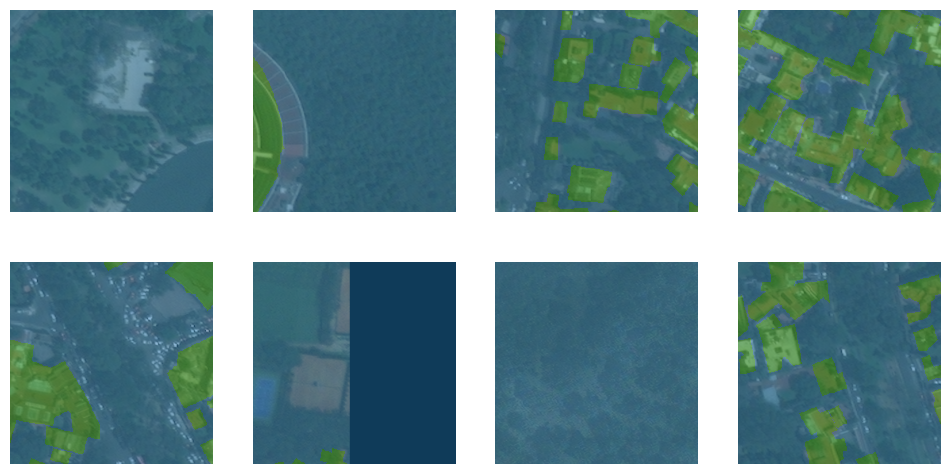

In [22]:
dls.show_batch()

In [23]:
learn = unet_learner(
    dls, 
    resnet18, 
    metrics=DiceMulti(axis=1), 
    self_attention=True, 
    act_cls=Mish,
    loss_func = DiceLoss(),
    pretrained=True,
    n_out = 5 # set codes implicitly later
)
# learn.summary()

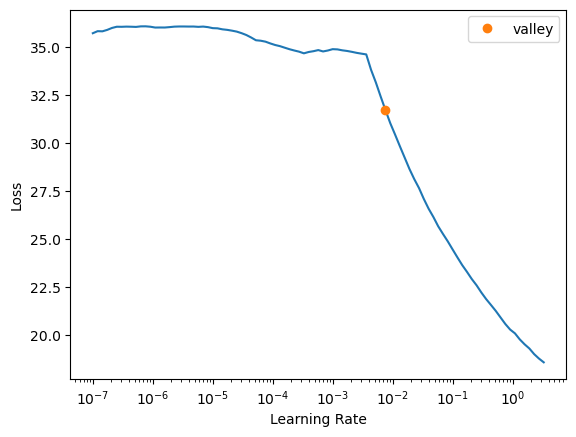

In [24]:
# something screwy going on with this... why does it shoot down??
# why does it want the learning rate to be so big???
lr = learn.lr_find()

In [31]:
#lr = lr[0]; lr
lr = 0.1
#https://towardsdatascience.com/implementing-a-batch-size-finder-in-fastai-how-to-get-a-4x-speedup-with-better-generalization-813d686f6bdf
# automatic batch finding??

In [32]:
# automatically does applies all of Leslie Smith's tricks-- 1cycle, freezing, discrinatory lr

# model isn't changing at all right now-- activations must be "dead"
# data isn't scaled....

#even worse score using default learner...
learn.fine_tune(epochs=3,
                base_lr=lr,
                freeze_epochs=2,
                cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2)
               )

epoch,train_loss,valid_loss,dice_multi,time
0,8.594163,8.423440,0.167272,01:37
1,8.449068,8.423440,0.167272,01:38


epoch,train_loss,valid_loss,dice_multi,time
0,8.494938,8.423440,0.167272,01:41
1,8.703302,8.423440,0.167272,01:41
2,8.527547,8.423440,0.167272,01:41


No improvement since epoch 0: early stopping


In [ ]:
learn.show_results(max_n=8)